# County-by-county results in 2018, 2021 statewide races

### Load python tools

In [1]:
%load_ext lab_black

In [4]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_latimes as lat
import jenkspy

In [5]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")

ThemeRegistry.enable('latimes')

In [6]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()
pd.options.display.max_colwidth = None

### FIPS codes for counties

In [10]:
fips = pd.read_html(
    "https://www.nrcs.usda.gov/wps/portal/nrcs/detail/ca/home/?cid=nrcs143_013697",
    attrs={"class": "data"},
)[0]

In [11]:
ca_fips = fips[fips["State"] == "CA"].copy()

In [12]:
ca_fips["FIPS"] = ca_fips["FIPS"].astype("str").str[1:]
ca_fips["Name"] = ca_fips["Name"].str.upper()

---

### Read 2018 data from Secretary of State election reports

In [14]:
# https://www.sos.ca.gov/elections/prior-elections/statewide-election-results/general-election-november-6-2018/statement-vote
then = pd.read_excel("data/raw/gov_by_county_2018.xls")

In [15]:
then.rename(
    columns={
        "County": "county",
        "Democratic": "newsom",
        "Republican": "not_newsom",
        "Votes": "votes",
        "Democratic_PCT": "newsom_pct",
        "Republican_PCT": "not_newsom_pct",
        "Year": "year",
    },
    inplace=True,
)

In [16]:
then.head()

,county,newsom,not_newsom,votes,newsom_pct,not_newsom_pct,year
0,Alameda,462558,111677,574235,0.81,0.19,2018
1,Alpine,386,229,615,0.63,0.37,2018
2,Amador,6237,11356,17593,0.35,0.65,2018
3,Butte,41500,47226,88726,0.47,0.53,2018
4,Calaveras,7765,13845,21610,0.36,0.64,2018


### Read 2021 results from AP

In [17]:
results = pd.read_csv(
    "https://elections-2020-backend-dev.s3.amazonaws.com/2021-09-14/data/county_ap_data_candidates.csv",
    dtype={"code": str},
)

### Just the yes/no question

In [18]:
results_gov = (
    results[results["description"] == "Recall Governor Newsom"]
    .reset_index(drop=True)
    .copy()
)

### Widen the dataframe

In [19]:
results_gov_pivot = results_gov.pivot_table(
    index=["name", "code"], columns="family_name", values="votes"
).reset_index()

### Newsom share

In [20]:
results_gov_pivot["votes"] = results_gov_pivot["No"] + results_gov_pivot["Yes"]
results_gov_pivot["newsom_pct"] = round(
    results_gov_pivot["No"] / results_gov_pivot["votes"], 2
)
results_gov_pivot["not_newsom_pct"] = round(
    results_gov_pivot["Yes"] / results_gov_pivot["votes"], 2
)

### Format similarly to 2018 results

In [21]:
results_gov_pivot["year"] = "2021"

In [22]:
results_gov_pivot.drop(["code"], axis=1, inplace=True)

In [23]:
results_gov_pivot.rename(
    columns={
        "name": "county",
        "No": "newsom",
        "Yes": "not_newsom",
    },
    inplace=True,
)

In [24]:
now = results_gov_pivot.copy()

### Concatenate into one dataframe

In [25]:
src = pd.concat([then, now])
src.columns = src.columns.str.lower()
src["county"] = src["county"].str.upper()

In [26]:
src.head()

,county,newsom,not_newsom,votes,newsom_pct,not_newsom_pct,year
0,ALAMEDA,462558,111677,574235,0.81,0.19,2018
1,ALPINE,386,229,615,0.63,0.37,2018
2,AMADOR,6237,11356,17593,0.35,0.65,2018
3,BUTTE,41500,47226,88726,0.47,0.53,2018
4,CALAVERAS,7765,13845,21610,0.36,0.64,2018


In [27]:
src.tail()

,county,newsom,not_newsom,votes,newsom_pct,not_newsom_pct,year
53,TULARE,30597,43363,73960,0.41,0.59,2021
54,TUOLUMNE,9267,14148,23415,0.40,0.60,2021
55,VENTURA,140083,95203,235286,0.60,0.40,2021
56,YOLO,37591,15052,52643,0.71,0.29,2021
57,YUBA,5208,8084,13292,0.39,0.61,2021


### Merge in the FIPS codes

In [28]:
df = pd.merge(src, ca_fips, left_on="county", right_on="Name")

In [29]:
df.drop(["Name", "State"], axis=1, inplace=True)

---

### Who's the leader, and by what margin? 

In [30]:
df["leader"] = df[["newsom", "not_newsom"]].idxmax(axis="columns")

In [31]:
def margin_calc(x):
    if (x["newsom"] - x["not_newsom"]) > 0:
        x["leader_margin"] = x["newsom"] - x["not_newsom"]
    else:
        x["leader_margin"] = (x["newsom"] - x["not_newsom"]) * -1
    return x

In [32]:
df = df.apply(lambda x: margin_calc(x), axis=1)

In [33]:
df.head()

,county,newsom,not_newsom,votes,newsom_pct,not_newsom_pct,year,FIPS,leader,leader_margin
0,ALAMEDA,462558,111677,574235,0.81,0.19,2018,001,newsom,350881
1,ALAMEDA,287014,60716,347730,0.83,0.17,2021,001,newsom,226298
2,ALPINE,386,229,615,0.63,0.37,2018,003,newsom,157
3,ALPINE,340,218,558,0.61,0.39,2021,003,newsom,122
4,AMADOR,6237,11356,17593,0.35,0.65,2018,005,not_newsom,5119


---

### Aggregate by year

In [34]:
results_years = (
    df.groupby(["year"])
    .agg(
        {
            "newsom": sum,
            "not_newsom": sum,
            "votes": sum,
        }
    )
    .reset_index()
)
results_years

,year,newsom,not_newsom,votes
0,2018,7721410,4742825,12464235
1,2021,5840283,3297145,9137428


In [35]:
results_years_la = (
    df[df["county"] == "LOS ANGELES"]
    .groupby(["year"])
    .agg(
        {
            "newsom": sum,
            "not_newsom": sum,
            "votes": sum,
        }
    )
    .reset_index()
)
results_years_la

,year,newsom,not_newsom,votes
0,2018,2114699,826402,2941101
1,2021,1598140,657584,2255724


In [36]:
results_years_la["d_pct"] = (
    (results_years_la["newsom"] / results_years_la["votes"]) * 100
).round(0)
results_years_la["r_pct"] = (
    (results_years_la["not_newsom"] / results_years_la["votes"]) * 100
).round(0)

In [37]:
results_years["d_pct"] = (results_years["newsom"] / results_years["votes"]).round(2)
results_years["r_pct"] = (results_years["not_newsom"] / results_years["votes"]).round(2)

In [38]:
results_years_la.head()

,year,newsom,not_newsom,votes,d_pct,r_pct
0,2018,2114699,826402,2941101,72.0,28.0
1,2021,1598140,657584,2255724,71.0,29.0


In [39]:
results_years_melt = pd.melt(
    results_years,
    id_vars="year",
    value_vars=["newsom", "not_newsom"],
    var_name="party",
    value_name="total",
)

In [40]:
results_years_melt

,year,party,total
0,2018,newsom,7721410
1,2021,newsom,5840283
2,2018,not_newsom,4742825
3,2021,not_newsom,3297145


In [41]:
alt.Chart(results_years_melt).mark_bar().encode(
    x=alt.X(
        "total:Q",
        title="vote share",
        stack="normalize",
        axis=alt.Axis(format="%", tickCount=5, domainOpacity=0, tickSize=0, grid=False),
    ),
    y=alt.Y(
        "year:O",
        title=" ",
        axis=alt.Axis(domainOpacity=0, tickSize=0, grid=False, offset=10),
    ),
    color=alt.Color(
        "party",
        title="",
        scale=alt.Scale(domain=["newsom", "not_newsom"], range=["#5789b8", "#d94f54"]),
    ),
    order=alt.Order("total", sort="descending"),
).properties(height=100, title="Vote totals by year").configure_legend(
    orient="top"
).configure_view(
    strokeOpacity=0
).configure_axis(
    labelFontSize=13
)

alt.Chart(...)

---

In [42]:
df_pivot = df.pivot_table(
    columns="year",
    index=["county", "FIPS"],
    values=["newsom", "not_newsom", "votes"],
).reset_index()

In [43]:
df_pivot.head()

county FIPS  newsom         not_newsom          votes        
year                    2018    2021       2018   2021    2018    2021
0       ALAMEDA  001  462558  287014     111677  60716  574235  347730
1        ALPINE  003     386     340        229    218     615     558
2        AMADOR  005    6237    6411      11356  10971   17593   17382
3         BUTTE  007   41500   31774      47226  35182   88726   66956
4     CALAVERAS  009    7765    7106      13845  11450   21610   18556

In [44]:
df_pivot.columns = df_pivot.columns.to_series().str.join("_")

In [45]:
df_pivot.columns = [
    "county",
    "fips",
    "newsom_2018",
    "newsom_2021",
    "not_newsom_2018",
    "not_newsom_2021",
    "votes_2018",
    "votes_2021",
]

In [46]:
df_pivot["d_pct_18"] = (df_pivot["newsom_2018"] / df_pivot["votes_2018"]).round(3) * 100
df_pivot["d_pct_21"] = (df_pivot["newsom_2021"] / df_pivot["votes_2021"]).round(3) * 100
df_pivot["r_pct_18"] = (df_pivot["not_newsom_2018"] / df_pivot["votes_2018"]).round(3) * 100
df_pivot["r_pct_21"] = (df_pivot["not_newsom_2021"] / df_pivot["votes_2021"]).round(3) * 100

In [62]:
df_pivot["newsom_pct_2018_votes"] = (
    df_pivot["newsom_2021"] / df_pivot["newsom_2018"]
).round(3) * 100
df_pivot["not_newsom_pct_2018_votes"] = (
    df_pivot["not_newsom_2021"] / df_pivot["not_newsom_2018"]
).round(3) * 100
df_pivot["pct_2018_votes_spread"] = (
    df_pivot["newsom_pct_2018_votes"] - df_pivot["not_newsom_pct_2018_votes"]
)

In [63]:
df_pivot["d_change"] = df_pivot["d_pct_21"] - df_pivot["d_pct_18"]
df_pivot["r_change"] = df_pivot["r_pct_21"] - df_pivot["r_pct_18"]

In [64]:
df_pivot["leader_2021"] = df_pivot[["d_pct_21", "r_pct_21"]].idxmax(axis="columns")
df_pivot["leader_2018"] = df_pivot[["d_pct_18", "r_pct_18"]].idxmax(axis="columns")

In [65]:
df_pivot["leader_2018"] = (
    df_pivot["leader_2018"]
    .str.replace("r_pct_18", "R", regex=False)
    .str.replace("d_pct_18", "D", regex=False)
)
df_pivot["leader_2021"] = (
    df_pivot["leader_2021"]
    .str.replace("r_pct_21", "R", regex=False)
    .str.replace("d_pct_21", "D", regex=False)
)

### Places that changed the most away from Newsom

In [66]:
df_pivot.sort_values("d_change", ascending=True).head(10)

,county,fips,newsom_2018,newsom_2021,not_newsom_2018,not_newsom_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018,newsom_pct_2018_votes,not_newsom_pct_2018_votes,pct_2018_votes_spread
17,LASSEN,035,2043,1357,6973,6590,9016,7947,22.7,17.1,77.3,82.9,-5.6,5.6,R,R,66.4,94.5,-28.1
15,KINGS,031,12275,8799,17976,14828,30251,23627,40.6,37.2,59.4,62.8,-3.4,3.4,R,R,71.7,82.5,-10.8
1,ALPINE,003,386,340,229,218,615,558,62.8,60.9,37.2,39.1,-1.9,1.9,D,D,88.1,95.2,-7.1
23,MERCED,047,30783,18168,28424,18130,59207,36298,52.0,50.1,48.0,49.9,-1.9,1.9,D,D,59.0,63.8,-4.8
24,MODOC,049,820,706,2628,2505,3448,3211,23.8,22.0,76.2,78.0,-1.8,1.8,R,R,86.1,95.3,-9.2
53,TULARE,107,42702,30597,57012,43363,99714,73960,42.8,41.4,57.2,58.6,-1.4,1.4,R,R,71.7,76.1,-4.4
51,TEHAMA,103,5756,2035,15137,5721,20893,7756,27.5,26.2,72.5,73.8,-1.3,1.3,R,R,35.4,37.8,-2.4
18,LOS ANGELES,037,2114699,1598140,826402,657584,2941101,2255724,71.9,70.8,28.1,29.2,-1.1,1.1,D,D,75.6,79.6,-4.0
49,STANISLAUS,099,77220,50929,79751,54507,156971,105436,49.2,48.3,50.8,51.7,-0.9,0.9,R,R,66.0,68.3,-2.3
12,IMPERIAL,025,20573,8830,12785,5572,33358,14402,61.7,61.3,38.3,38.7,-0.4,0.4,D,D,42.9,43.6,-0.7


### Places that changed the most toward Newsom

In [67]:
df_pivot.sort_values("d_change", ascending=False).head(10)

,county,fips,newsom_2018,newsom_2021,not_newsom_2018,not_newsom_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018,newsom_pct_2018_votes,not_newsom_pct_2018_votes,pct_2018_votes_spread
16,LAKE,033,10869,5605,10280,3728,21149,9333,51.4,60.1,48.6,39.9,8.7,-8.7,D,D,51.6,36.3,15.3
30,PLACER,061,72270,56455,103157,59059,175427,115514,41.2,48.9,58.8,51.1,7.7,-7.7,R,R,78.1,57.3,20.8
39,SAN LUIS OBISPO,079,65117,32903,61137,23306,126254,56209,51.6,58.5,48.4,41.5,6.9,-6.9,D,D,50.5,38.1,12.4
27,NAPA,055,36513,26526,19834,11098,56347,37624,64.8,70.5,35.2,29.5,5.7,-5.7,D,D,72.6,56.0,16.6
48,SONOMA,097,152040,112264,58338,31939,210378,144203,72.3,77.9,27.7,22.1,5.6,-5.6,D,D,73.8,54.7,19.1
33,SACRAMENTO,067,302696,196291,212010,110502,514706,306793,58.8,64.0,41.2,36.0,5.2,-5.2,D,D,64.8,52.1,12.7
26,MONTEREY,053,76648,59525,39516,24456,116164,83981,66.0,70.9,34.0,29.1,4.9,-4.9,D,D,77.7,61.9,15.8
6,CONTRA COSTA,013,283805,252879,132345,92905,416150,345784,68.2,73.1,31.8,26.9,4.9,-4.9,D,D,89.1,70.2,18.9
44,SHASTA,089,20256,15726,49825,30932,70081,46658,28.9,33.7,71.1,66.3,4.8,-4.8,R,R,77.6,62.1,15.5
20,MARIN,041,103671,79616,26750,14873,130421,94489,79.5,84.3,20.5,15.7,4.8,-4.8,D,D,76.8,55.6,21.2


### Places that captured the most Newsom votes compared to 2018 counts

In [68]:
df_pivot.sort_values("newsom_pct_2018_votes", ascending=False).head(10)

,county,fips,newsom_2018,newsom_2021,not_newsom_2018,not_newsom_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018,newsom_pct_2018_votes,not_newsom_pct_2018_votes,pct_2018_votes_spread
2,AMADOR,005,6237,6411,11356,10971,17593,17382,35.5,36.9,64.5,63.1,1.4,-1.4,R,R,102.8,96.6,6.2
54,TUOLUMNE,109,9294,9267,14580,14148,23874,23415,38.9,39.6,61.1,60.4,0.7,-0.7,R,R,99.7,97.0,2.7
21,MARIPOSA,043,3183,3086,5043,4572,8226,7658,38.7,40.3,61.3,59.7,1.6,-1.6,R,R,97.0,90.7,6.3
45,SIERRA,091,599,555,1068,903,1667,1458,35.9,38.1,64.1,61.9,2.2,-2.2,R,R,92.7,84.6,8.1
4,CALAVERAS,009,7765,7106,13845,11450,21610,18556,35.9,38.3,64.1,61.7,2.4,-2.4,R,R,91.5,82.7,8.8
6,CONTRA COSTA,013,283805,252879,132345,92905,416150,345784,68.2,73.1,31.8,26.9,4.9,-4.9,D,D,89.1,70.2,18.9
7,DEL NORTE,015,3441,3038,4887,4198,8328,7236,41.3,42.0,58.7,58.0,0.7,-0.7,R,R,88.3,85.9,2.4
1,ALPINE,003,386,340,229,218,615,558,62.8,60.9,37.2,39.1,-1.9,1.9,D,D,88.1,95.2,-7.1
31,PLUMAS,063,3433,3008,5807,5106,9240,8114,37.2,37.1,62.8,62.9,-0.1,0.1,R,R,87.6,87.9,-0.3
24,MODOC,049,820,706,2628,2505,3448,3211,23.8,22.0,76.2,78.0,-1.8,1.8,R,R,86.1,95.3,-9.2


### Places that captured the most not-Newsom votes compared to 2018 counts

In [69]:
df_pivot.sort_values("not_newsom_pct_2018_votes", ascending=False).head(10)

,county,fips,newsom_2018,newsom_2021,not_newsom_2018,not_newsom_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018,newsom_pct_2018_votes,not_newsom_pct_2018_votes,pct_2018_votes_spread
54,TUOLUMNE,109,9294,9267,14580,14148,23874,23415,38.9,39.6,61.1,60.4,0.7,-0.7,R,R,99.7,97.0,2.7
2,AMADOR,005,6237,6411,11356,10971,17593,17382,35.5,36.9,64.5,63.1,1.4,-1.4,R,R,102.8,96.6,6.2
24,MODOC,049,820,706,2628,2505,3448,3211,23.8,22.0,76.2,78.0,-1.8,1.8,R,R,86.1,95.3,-9.2
1,ALPINE,003,386,340,229,218,615,558,62.8,60.9,37.2,39.1,-1.9,1.9,D,D,88.1,95.2,-7.1
17,LASSEN,035,2043,1357,6973,6590,9016,7947,22.7,17.1,77.3,82.9,-5.6,5.6,R,R,66.4,94.5,-28.1
21,MARIPOSA,043,3183,3086,5043,4572,8226,7658,38.7,40.3,61.3,59.7,1.6,-1.6,R,R,97.0,90.7,6.3
31,PLUMAS,063,3433,3008,5807,5106,9240,8114,37.2,37.1,62.8,62.9,-0.1,0.1,R,R,87.6,87.9,-0.3
7,DEL NORTE,015,3441,3038,4887,4198,8328,7236,41.3,42.0,58.7,58.0,0.7,-0.7,R,R,88.3,85.9,2.4
45,SIERRA,091,599,555,1068,903,1667,1458,35.9,38.1,64.1,61.9,2.2,-2.2,R,R,92.7,84.6,8.1
4,CALAVERAS,009,7765,7106,13845,11450,21610,18556,35.9,38.3,64.1,61.7,2.4,-2.4,R,R,91.5,82.7,8.8


### Places that had the biggest difference in enthusiasm between Newsom and non-Newsom voters

In [70]:
df_pivot.sort_values("pct_2018_votes_spread", ascending=False)

,county,fips,newsom_2018,newsom_2021,not_newsom_2018,not_newsom_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018,newsom_pct_2018_votes,not_newsom_pct_2018_votes,pct_2018_votes_spread
20,MARIN,041,103671,79616,26750,14873,130421,94489,79.5,84.3,20.5,15.7,4.8,-4.8,D,D,76.8,55.6,21.2
30,PLACER,061,72270,56455,103157,59059,175427,115514,41.2,48.9,58.8,51.1,7.7,-7.7,R,R,78.1,57.3,20.8
48,SONOMA,097,152040,112264,58338,31939,210378,144203,72.3,77.9,27.7,22.1,5.6,-5.6,D,D,73.8,54.7,19.1
6,CONTRA COSTA,013,283805,252879,132345,92905,416150,345784,68.2,73.1,31.8,26.9,4.9,-4.9,D,D,89.1,70.2,18.9
42,SANTA CLARA,085,438758,367471,175791,116687,614549,484158,71.4,75.9,28.6,24.1,4.5,-4.5,D,D,83.8,66.4,17.4
27,NAPA,055,36513,26526,19834,11098,56347,37624,64.8,70.5,35.2,29.5,5.7,-5.7,D,D,72.6,56.0,16.6
40,SAN MATEO,081,213282,174757,70242,46076,283524,220833,75.2,79.1,24.8,20.9,3.9,-3.9,D,D,81.9,65.6,16.3
26,MONTEREY,053,76648,59525,39516,24456,116164,83981,66.0,70.9,34.0,29.1,4.9,-4.9,D,D,77.7,61.9,15.8
44,SHASTA,089,20256,15726,49825,30932,70081,46658,28.9,33.7,71.1,66.3,4.8,-4.8,R,R,77.6,62.1,15.5
16,LAKE,033,10869,5605,10280,3728,21149,9333,51.4,60.1,48.6,39.9,8.7,-8.7,D,D,51.6,36.3,15.3


In [116]:
df_pivot[df_pivot["county"] == "LOS ANGELES"]

,county,fips,newsom_2018,newsom_2021,not_newsom_2018,not_newsom_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018
18,LOS ANGELES,037,2114699,1598140,826402,657584,2941101,2255724,71.9,70.8,28.1,29.2,-1.1,1.1,D,D


In [103]:
df_pivot["flipped"] = df_pivot["leader_2021"] != df_pivot["leader_2018"]

In [105]:
df_pivot.head()

,county,fips,dem_2018,dem_2021,rep_2018,rep_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018,flipped
0,ALAMEDA,001,462558,287014,111677,60716,574235,347730,80.6,82.5,19.4,17.5,1.9,-1.9,D,D,False
1,ALPINE,003,386,340,229,218,615,558,62.8,60.9,37.2,39.1,-1.9,1.9,D,D,False
2,AMADOR,005,6237,6411,11356,10971,17593,17382,35.5,36.9,64.5,63.1,1.4,-1.4,R,R,False
3,BUTTE,007,41500,31774,47226,35182,88726,66956,46.8,47.5,53.2,52.5,0.7,-0.7,R,R,False
4,CALAVERAS,009,7765,7106,13845,11450,21610,18556,35.9,38.3,64.1,61.7,2.4,-2.4,R,R,False


---

### Geography

In [47]:
# https://gis.data.ca.gov/datasets/c933349c56f640edba968f208063eee0_1/

### Read county boundaries

In [48]:
counties_geo = gpd.read_file("data/raw/counties.json")

In [49]:
counties_geo.columns = counties_geo.columns.str.lower()
counties_geo.columns

Index(['statefips', 'countyfips', 'fips', 'name', 'geometry'], dtype='object')

In [50]:
counties_geo_slim = counties_geo[["name", "countyfips", "geometry"]].copy()

<AxesSubplot:>

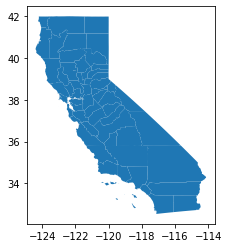

In [51]:
counties_geo_slim.plot()

In [52]:
counties_geo_slim["name"] = counties_geo_slim["name"].str.upper()

### Merge with election results

In [53]:
results_geo = counties_geo_slim.merge(
    df_pivot,
    right_on="county",
    left_on="name",
)

<AxesSubplot:>

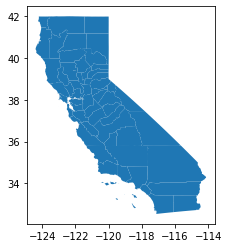

In [54]:
results_geo.plot()

In [55]:
results_geo.to_file("data/processed/gov_results_18-21_geo.geojson", driver="GeoJSON")

---

### Exports

In [56]:
df_pivot_export = df_pivot.copy()

In [57]:
df_pivot_export["county"] = df_pivot_export["county"].str.title()

In [58]:
df_pivot_export.to_json(
    "data/processed/gov_race_change_counties.json", indent=2, orient="records"
)

In [59]:
df_pivot_export.to_json("../_data/elections_by_county.json", indent=2, orient="records")

In [60]:
df_pivot_export.sort_values("d_change", ascending=False).head(10)

,county,fips,dem_2018,dem_2021,rep_2018,rep_2021,votes_2018,votes_2021,d_pct_18,d_pct_21,r_pct_18,r_pct_21,d_change,r_change,leader_2021,leader_2018
16,Lake,033,10869,5605,10280,3728,21149,9333,51.4,60.1,48.6,39.9,8.7,-8.7,D,D
30,Placer,061,72270,56455,103157,59059,175427,115514,41.2,48.9,58.8,51.1,7.7,-7.7,R,R
39,San Luis Obispo,079,65117,32903,61137,23306,126254,56209,51.6,58.5,48.4,41.5,6.9,-6.9,D,D
27,Napa,055,36513,26526,19834,11098,56347,37624,64.8,70.5,35.2,29.5,5.7,-5.7,D,D
48,Sonoma,097,152040,112264,58338,31939,210378,144203,72.3,77.9,27.7,22.1,5.6,-5.6,D,D
33,Sacramento,067,302696,196291,212010,110502,514706,306793,58.8,64.0,41.2,36.0,5.2,-5.2,D,D
26,Monterey,053,76648,59525,39516,24456,116164,83981,66.0,70.9,34.0,29.1,4.9,-4.9,D,D
6,Contra Costa,013,283805,252879,132345,92905,416150,345784,68.2,73.1,31.8,26.9,4.9,-4.9,D,D
44,Shasta,089,20256,15726,49825,30932,70081,46658,28.9,33.7,71.1,66.3,4.8,-4.8,R,R
20,Marin,041,103671,79616,26750,14873,130421,94489,79.5,84.3,20.5,15.7,4.8,-4.8,D,D


In [61]:
df[df["year"] == 2021].to_json(
    "data/processed/gov_race_keyed_2021.json", indent=2, orient="records"
)

In [62]:
results_years_la.to_json(
    "../_data/los_angeles_vote_2018_2021.json", indent=2, orient="records"
)

### Export slim table

In [63]:
df[df["year"] == 2021][["county", "newsom_pct", "not_newsom_pct", "leader"]].to_json(
    "data/processed/newsom_by_county.json", indent=2, orient="records"
)